In [8]:
import numpy as np

# Normalize the data.
from sklearn import preprocessing
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize
import scipy.spatial.distance as spdist

def pass_arg(Xx, nsim, tr_size):

    print("tr_Size:",tr_size)
    
#     Compute the RMSE
    def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(np.mean((y_pred-y_true)**2))
    
    # Experimental data
    data = np.loadtxt('../data/labeled_data.dat')
    x_labeled = data[:, :2].astype(np.float64) # -2 because we do not need porosity predictions
    y_labeled = data[:, -2:-1].astype(np.float64) # dimensionless bond length and porosity measurements

    # normalize dataset with MinMaxScaler
    scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
    x_labeled = scaler.fit_transform(x_labeled)
    # y_labeled = scaler.fit_transform(y_labeled)

    tr_size = int(tr_size)

    # train and test data
    trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]
    testX, testY = x_labeled[30:,:], y_labeled[30:]

    # Physics data
    data_phyloss = np.loadtxt('../data/unlabeled_data_BK_constw_v2_1525.dat')
    x_unlabeled = data_phyloss[:, :]

    x_unlabeled1 = x_unlabeled[:1303, :2]
    x_unlabeled2 = x_unlabeled[-6:, :2]
    y_unlabeled1 = data_phyloss[:1303, -2:-1]
    y_unlabeled2 = data_phyloss[-6:, -2:-1]

    x_unlabeled = np.vstack((x_unlabeled1,x_unlabeled2))
    y_unlabeled = np.vstack((y_unlabeled1,y_unlabeled2))

    # normalize dataset with MinMaxScaler
    scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
    x_unlabeled = scaler.fit_transform(x_unlabeled)


    def covSEard(hyp=None, x=None, z=None):
        ''' Squared Exponential covariance function with Automatic Relevance Detemination
         (ARD) distance measure. The covariance function is parameterized as:

         k(x^p,x^q) = sf2 * exp(-(x^p - x^q)' * inv(P) * (x^p - x^q)/2)

         where the P matrix is diagonal with ARD parameters ell_1^2,...,ell_D^2, where
         D is the dimension of the input space and sf2 is the signal variance.

         The hyperparameters are:

         hyp = [ log(ell_1)
                 log(ell_2)
                 ...
                 log(ell_D)
                 log(sqrt(sf2)) ]
        '''

        [n, D] = x.shape
        ell = 1/np.array(hyp[0:D])        # characteristic length scale
        
        
        sf2 = np.array(hyp[D])**2         # signal variance
        tmp = np.dot(np.diag(ell),x.T).T
        A = spdist.cdist(np.dot(np.diag(ell),x.T).T, np.dot(np.diag(ell),z.T).T, 'sqeuclidean') # cross covariances
        A = sf2*np.exp(-0.5*A)  

        return A


    def posterior_predictive(X_s, X_train, Y_train, l1=.1, l2=.1, sigma_f=.1, sigma_y=0):
        '''  
        Computes the suffifient statistics of the GP posterior predictive distribution 
        from m training data X_train and Y_train and n new inputs X_s.

        Args:
            X_s: New input locations (n x d).
            X_train: Training locations (m x d).
            Y_train: Training targets (m x 1).
            l: Kernel length parameter.
            sigma_f: Kernel vertical variation parameter.
            sigma_y: Noise parameter.

        Returns:
            Posterior mean vector (n x d) and covariance matrix (n x n).
        '''
        K = covSEard(hyp=[l1,l2,sigma_f], x=X_train, z=X_train) + sigma_y**2 * np.eye(len(X_train))
        K_s = covSEard(hyp=[l1,l2,sigma_f], x=X_train, z=X_s)
        K_ss = covSEard(hyp=[l1,l2,sigma_f], x=X_s, z=X_s)  + 1e-8 * np.eye(len(X_s))
#         K_inv = inv(K)
        K_inv = np.linalg.pinv(K)
    
        # Equation (4)
        mu_s = K_s.T.dot(K_inv).dot(Y_train)

        # Equation (5)
        cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
        
        return mu_s, cov_s


    def nll_fn(X_train, Y_train, noise=0, naive=False):
        '''
        Returns a function that computes the negative log marginal
        likelihood for training data X_train and Y_train and given 
        noise level.

        Args:
            X_train: training locations (m x d).
            Y_train: training targets (m x 1).
            noise: known noise level of Y_train.
            naive: if True use a naive implementation of Eq. (7), if 
                   False use a numerically more stable implementation. 

        Returns:
            Minimization objective.
        '''

        def nll_stable(theta):
            # Numerically more stable implementation of Eq. (7) as described
            # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
            # 2.2, Algorithm 2.1.
            K = covSEard(hyp=[theta[0],theta[1],theta[2]], x=X_train, z=X_train) + \
                noise**2 * np.eye(len(X_train))
            
            K += 1e-6 * np.eye(*K.shape)
            L = cholesky(K)
            return np.sum(np.log(np.diagonal(L))) + \
                   0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
                   0.5 * len(X_train) * np.log(2*np.pi)

        if naive:
            return nll_naive
        else:
            return nll_stable

        
    def posterior_predictive_discp(X_s, X_train, Y_train, l1=.1, l2=.1, sigma_f=.1, sigma_y=1e-2):
        '''  
        Computes the suffifient statistics of the GP posterior predictive distribution 
        from m training data X_train and Y_train and n new inputs X_s.

        Args:
            X_s: New input locations (n x d).
            X_train: Training locations (m x d).
            Y_train: Training targets (m x 1).
            l: Kernel length parameter.
            sigma_f: Kernel vertical variation parameter.
            sigma_y: Noise parameter.

        Returns:
            Posterior mean vector (n x d) and covariance matrix (n x n).
        '''
        K = covSEard(hyp=[l1,l2,sigma_f], x=X_train, z=X_train) + sigma_y**2 * np.eye(len(X_train))
        K_s = covSEard(hyp=[l1,l2,sigma_f], x=X_train, z=X_s)
        K_ss = covSEard(hyp=[l1,l2,sigma_f], x=X_s, z=X_s)  + 1e-8 * np.eye(len(X_s))
#         K_inv = inv(K)
        K_inv = np.linalg.pinv(K)
    
        # Equation (4)
        mu_s = K_s.T.dot(K_inv).dot(Y_train)

        # Equation (5)
        cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
        
        return mu_s, cov_s


    def nll_fn_discp(X_train, Y_train, naive=False):
        '''
        Returns a function that computes the negative log marginal
        likelihood for training data X_train and Y_train and given 
        noise level.

        Args:
            X_train: training locations (m x d).
            Y_train: training targets (m x 1).
            noise: known noise level of Y_train.
            naive: if True use a naive implementation of Eq. (7), if 
                   False use a numerically more stable implementation. 

        Returns:
            Minimization objective.
        '''

        def nll_stable_discp(theta):
            # Numerically more stable implementation of Eq. (7) as described
            # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
            # 2.2, Algorithm 2.1.
            K = covSEard(hyp=[theta[0],theta[1],theta[2]], x=X_train, z=X_train) + \
                theta[3]**2 * np.eye(len(X_train))
            
            K += 1e-6 * np.eye(*K.shape)
            L = cholesky(K)
            return np.sum(np.log(np.diagonal(L))) + \
                   0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
                   0.5 * len(X_train) * np.log(2*np.pi)

        return nll_stable_discp

        
    
    # Optimization - GP1 - for physics
    res1 = minimize(nll_fn(x_unlabeled, y_unlabeled), x0 = [.1, .1, .1], 
                   bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
                    method='L-BFGS-B')
    
    # GP (physics) predictions
    mu_s1, cov_s1 = posterior_predictive(trainX, x_unlabeled, y_unlabeled, *res1.x)
    
    # discrepancy
    discp = trainY - mu_s1
    
    # Optimization - GP2 - for discrepency
    res2 = minimize(nll_fn_discp(trainX, discp), x0 = [.1, .1, .1, 1e-3], 
                   bounds=((1e-5, None), (1e-5, None), (1e-5, None), (1e-7, None)),
                    method='L-BFGS-B')
    
    # GP (physics) predictions
    # mu_s2, cov_s2 = posterior_predictive_discp(trainX, trainX, discp, *res2.x)
    
    
    # GP (physics) predictions
    mu_s3, cov_s3 = posterior_predictive(testX, x_unlabeled, y_unlabeled, *res1.x)
    
    # GP (physics) predictions
    mu_s4, cov_s4 = posterior_predictive_discp(testX, trainX, discp, *res2.x)
    
#     print(mu_s2+mu_s1, discp)
    pred_mu = mu_s3+mu_s4
    pred_cov = cov_s3+cov_s4
    
#     print(f'After parameter optimization: l1={res.x[0]:.5f} l2={res.x[1]:.5f} sigma_f={res.x[2]:.5f}')
#     print(np.exp(res.x[0]),np.exp(res.x[1]), np.exp(res.x[2]))
    RMSE = []
    for ii in range(int(nsim)):
        samples = np.random.multivariate_normal(pred_mu.ravel(), pred_cov, 1)
        RMSE.append(root_mean_squared_error(testY, samples))
        
#         print("RMSE:", root_mean_squared_error(testY, samples))

#     return samples, RMSE
    return RMSE

In [9]:
mean_rmses=[]
std_rmses=[]
for ii in ([5,10,15,20,30]):
    test_rmse = pass_arg(1,50, ii)
    mean_rmse = np.mean(test_rmse)
    std_rmse = np.std(test_rmse)
    mean_rmses.append(mean_rmse)
    std_rmses.append(std_rmse)

tr_Size: 5


C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:205: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: covariance is not positive-semidefinite.


tr_Size: 10


C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:205: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: covariance is not positive-semidefinite.


tr_Size: 15


C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:205: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: covariance is not positive-semidefinite.


tr_Size: 20


C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:205: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: covariance is not positive-semidefinite.


tr_Size: 30


C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:205: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: covariance is not positive-semidefinite.


In [10]:
mean_rmses

[0.021543634321098407,
 0.027948028638562494,
 0.020109929168299172,
 0.02091854865278942,
 0.019663648751933157]

In [11]:
std_rmses

[0.0037020347401265346,
 0.0034834139754568987,
 0.0011804664389471484,
 0.0018174825550800135,
 0.0009194508446077711]

In [14]:
Xx = np.random.uniform(size=(3, 2))
ss, rmse = pass_arg(Xx, 100, 30)

tr_Size: 30


C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:205: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: covariance is not positive-semidefinite.


RMSE: 0.020248739201087725
RMSE: 0.019855318666829564
RMSE: 0.019753682170980807
RMSE: 0.020510976336362362
RMSE: 0.019201797328938643
RMSE: 0.0186904441945714
RMSE: 0.018464260807579735
RMSE: 0.021234568169793792
RMSE: 0.02057109689190307
RMSE: 0.019163702462285836
RMSE: 0.019672958289076666
RMSE: 0.01926100939483477
RMSE: 0.02145115203116223
RMSE: 0.01974547784345481
RMSE: 0.022133649104951157
RMSE: 0.018763336781457845
RMSE: 0.01996252772084699
RMSE: 0.018483726565608326
RMSE: 0.02124211093074169
RMSE: 0.018850085798463992
RMSE: 0.020056987272245298
RMSE: 0.020856763115576972
RMSE: 0.019361501332954424
RMSE: 0.021012623379733076
RMSE: 0.0201465208908012
RMSE: 0.018728153094267033
RMSE: 0.020493567535124355
RMSE: 0.019195348355886002
RMSE: 0.020272897074870944
RMSE: 0.019333228407999083
RMSE: 0.020052841557409176
RMSE: 0.018911206909689122
RMSE: 0.020808837789034917
RMSE: 0.018913012491508438
RMSE: 0.02098433582315564
RMSE: 0.020003814372168676
RMSE: 0.01978540531134652
RMSE: 0.01914

In [15]:
np.mean(rmse)

0.01996514973888765

C:\Users\berkc\Miniconda3\envs\R\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  


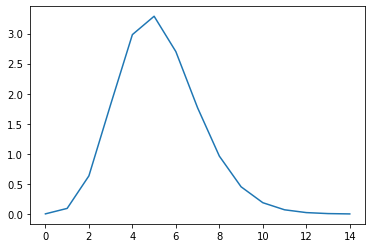

In [180]:
size = 15
x = scipy.arange(size)
pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
plt.plot(pdf_fitted, label='gamma')